In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier




In [2]:
df = pd.read_pickle('../../../data/trimmed_processed/WELFake.pkl')

x = df['text']
y = df['label']

## RANDOM FOREST MODEL

In [3]:
x_train,x_test,y_train,y_test = train_test_split(
    x,y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Reduce TF-IDF features before SVD
vectorizer = TfidfVectorizer(
    max_features=5000,  # Reduce from default (likely 10k+)
    stop_words='english',
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.8  # Ignore terms that appear in more than 80% of documents
)
x_train_tfidf = vectorizer.fit_transform(x_train)


# Now TruncatedSVD should work
tsvd = TruncatedSVD(n_components=300, random_state=42)
x_train_ts = tsvd.fit_transform(x_train_tfidf)

rf = RandomForestClassifier(
    n_estimators=400, max_depth=42, min_samples_leaf=2,
    n_jobs=-1, random_state=42, class_weight="balanced_subsample"
)
rf.fit(x_train_ts, y_train)

x_test_idf = vectorizer.transform(x_test)
x_test_ts = tsvd.transform(x_test_idf)
y_pred = rf.predict(x_test_ts)

              precision    recall  f1-score   support

        FAKE     0.9215    0.8900    0.9055      7006
        REAL     0.8994    0.9284    0.9137      7421

    accuracy                         0.9098     14427
   macro avg     0.9104    0.9092    0.9096     14427
weighted avg     0.9101    0.9098    0.9097     14427



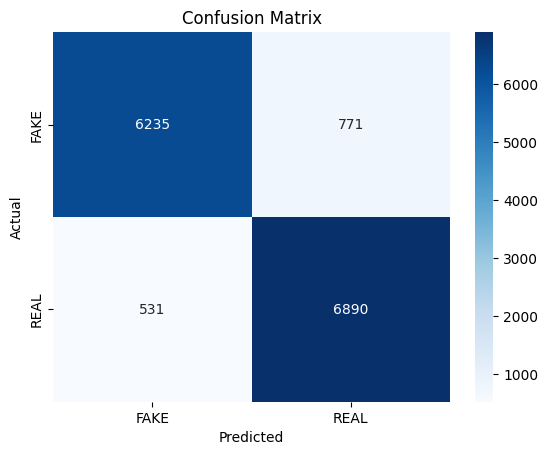

In [4]:
print(classification_report(y_test,y_pred, digits=4))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', xticklabels=rf.classes_,yticklabels=rf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## LOGISTIC REGRESSION

In [5]:
x_train,x_test,y_train,y_test = train_test_split(
    x,y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_df=0.8,
    stop_words='english'
)

x_train_tfidf = tfidf.fit_transform(x_train)
x_test_idf = tfidf.transform(x_test)



In [6]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(x_train_tfidf,y_train)

y_pred = clf.predict(x_test_idf)

              precision    recall  f1-score   support

        FAKE     0.9401    0.9402    0.9401      7006
        REAL     0.9435    0.9434    0.9435      7421

    accuracy                         0.9418     14427
   macro avg     0.9418    0.9418    0.9418     14427
weighted avg     0.9418    0.9418    0.9418     14427



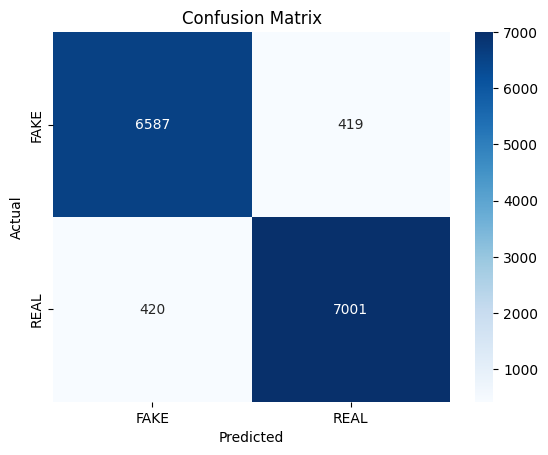

In [7]:
print(classification_report(y_test,y_pred, digits=4))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', xticklabels=clf.classes_,yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()